<a href="https://colab.research.google.com/github/bartwronski/BlogPostsExtraMaterial/blob/master/PBR_textures_low_rank_part_2_Kodak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage
import urllib.request
from zipfile import ZipFile

Load and display the images

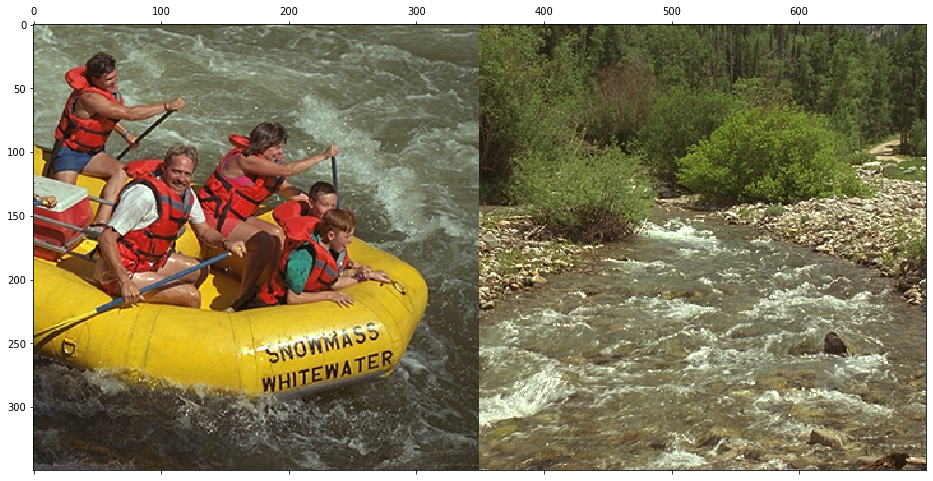

In [0]:
plt.rcParams['figure.figsize']=8,8
urllib.request.urlretrieve('https://www.dropbox.com/s/l6o1ejn8ek3ik5k/kodim13.png?dl=1', filename='kodim13.png')
test_img2 = cv2.imread('kodim13.png')[:,:,(2,1,0)] / 255.0
urllib.request.urlretrieve('https://www.dropbox.com/s/11rd44q5kdgdqki/kodim14.png?dl=1', filename='kodim14.png')
test_img = cv2.imread('kodim14.png')[:,:,(2,1,0)] / 255.0

plt.matshow(np.hstack((test_img, test_img2)))


Helper functions and RGB -> YUV, YUV -> RGB matrices.

In [0]:
def psnr(img1, img2, w = None):
  mse = np.mean( (img1 - img2) ** 2 )
  if mse == 0:
    return 100
  return -10 * np.log10(mse)

rgb2yuv = np.array([[0.29900, -0.16874,  0.50000],
                    [0.58700, -0.33126, -0.41869],
                    [0.11400, 0.50000, -0.08131]])
yuv2rgb = np.linalg.inv(rgb2yuv)

Convert Kodak images to YUV and display each 'plane'

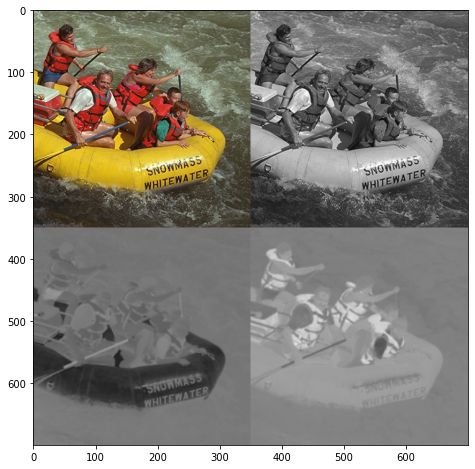

In [0]:
yuv_img = np.dot(test_img, rgb2yuv)
plt.imshow(np.vstack((np.hstack((test_img, yuv_img[:,:,[0,0,0]])),np.hstack((yuv_img[:,:,[1,1,1]]+0.5, yuv_img[:,:,[2,2,2]]+0.5)))))

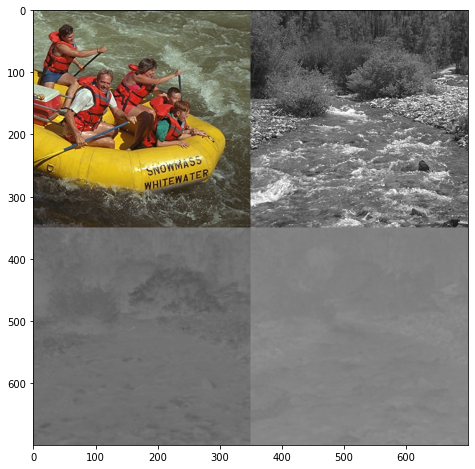

In [0]:
yuv_img = np.dot(test_img2, rgb2yuv)
plt.imshow(np.vstack((np.hstack((test_img, yuv_img[:,:,[0,0,0]])),np.hstack((yuv_img[:,:,[1,1,1]]+0.5, yuv_img[:,:,[2,2,2]]+0.5)))))

Covariance matrices of the Kodak images - original, and in YUV space

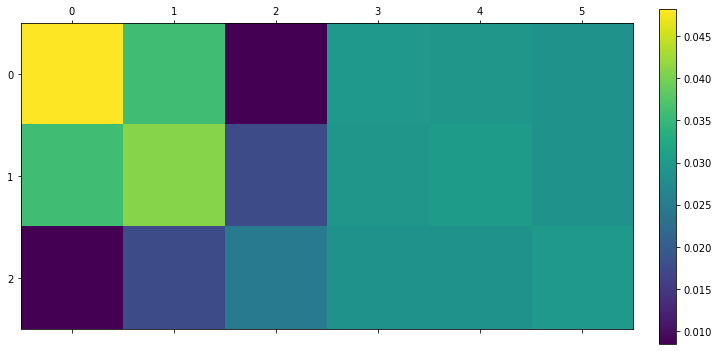

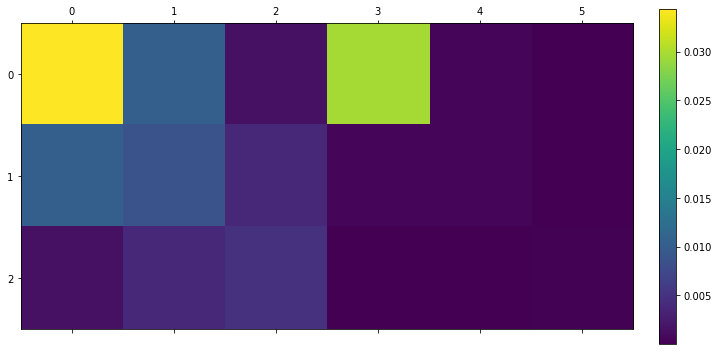

In [0]:
plt.rcParams['figure.figsize']=6,6
plt.matshow(np.abs(np.hstack((np.cov(test_img.reshape((350*350,3)).transpose()),np.cov(test_img2.reshape((350*350,3)).transpose())))))
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()
plt.matshow(np.abs(np.hstack((np.cov(np.transpose(np.dot(test_img, rgb2yuv).reshape((350*350,3)))),np.cov(np.transpose(np.dot(test_img2, rgb2yuv).reshape((350*350,3))))))))
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


Perform SVD on "flattened" images, convert SVD planes back, and display them.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


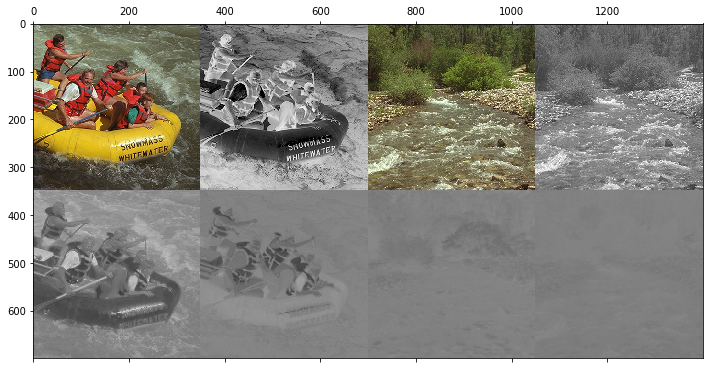

In [0]:
test_img_flatten = test_img.reshape((test_img.shape[0]*test_img.shape[1],test_img.shape[2]))
center = 1.0
u, s, v = np.linalg.svd(test_img_flatten - center * np.mean(test_img_flatten, axis=0), full_matrices=False)
u1, s1, v1 = u.copy(), s.copy(), v.copy()

imm = np.dot(u, np.diag(s)).reshape((test_img.shape[0],test_img.shape[1],test_img.shape[2]))
imm = imm / (2.0*np.max(imm)) + 0.5
r1 = np.vstack((np.hstack((test_img, imm[:,:,[0,0,0]])), np.hstack((imm[:,:,[1,1,1]], imm[:,:,[2,2,2]]))))

test_img_flatten = test_img2.reshape((test_img.shape[0]*test_img.shape[1],test_img.shape[2]))
u, s, v = np.linalg.svd(test_img_flatten - center * np.mean(test_img_flatten, axis=0), full_matrices=False)
u2, s2, v2 = u.copy(), s.copy(), v.copy()

imm = np.dot(u, np.diag(s)).reshape((test_img.shape[0],test_img.shape[1],test_img.shape[2]))
imm = imm / (2.0*np.max(imm)) + 0.5

plt.matshow(np.hstack((r1, np.vstack((np.hstack((test_img2, imm[:,:,[0,0,0]])), np.hstack((imm[:,:,[1,1,1]], imm[:,:,[2,2,2]])))))))

Various (co)variance plots.

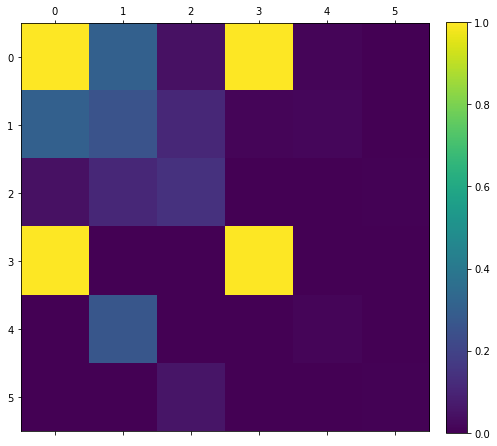

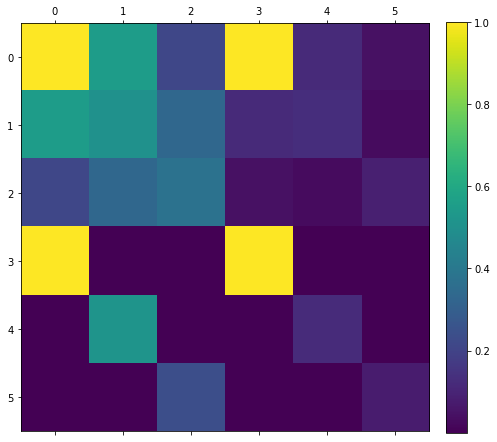

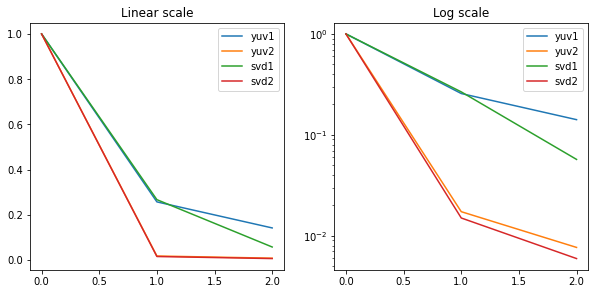

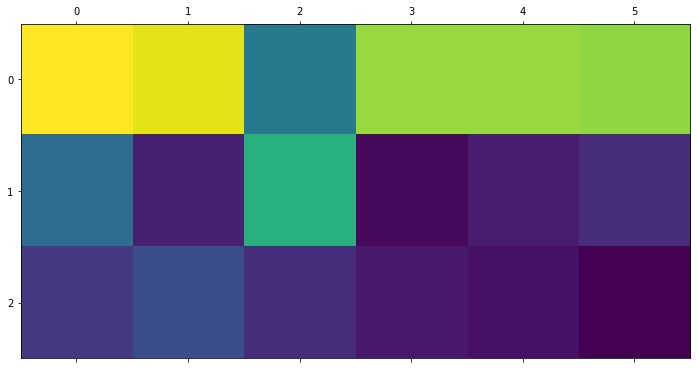

In [0]:
plt.rcParams['figure.figsize']=8,8
c11 = np.abs(np.cov(np.transpose(np.dot(test_img, rgb2yuv).reshape((350*350,3)))))
c11 /= np.max(c11)
c12 = np.abs(np.cov(np.transpose(np.dot(test_img2, rgb2yuv).reshape((350*350,3)))))
c12 /= np.max(c12)
c21 = np.abs(np.cov(np.transpose(np.dot(u1, np.diag(s1)))))
c21 /= np.max(c21)
c22 = np.abs(np.cov(np.transpose(np.dot(u2, np.diag(s2)))))
c22 /= np.max(c22)
plt.matshow(np.vstack((np.hstack((c11,c12)),np.hstack((c21,c22)))))
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

plt.matshow(np.sqrt(np.vstack((np.hstack((c11,c12)),np.hstack((c21,c22))))))
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

plt.rcParams['figure.figsize']=10,10
plt.subplot(2,2,1)
plt.plot(c11.diagonal(), label='yuv1')
plt.plot(c12.diagonal(), label='yuv2')
plt.plot(c21.diagonal(), label='svd1')
plt.plot(c22.diagonal(), label='svd2')
plt.legend()
plt.title('Linear scale')
ax = plt.subplot(2,2,2)
plt.plot(c11.diagonal(), label='yuv1')
plt.plot(c12.diagonal(), label='yuv2')
plt.plot(c21.diagonal(), label='svd1')
plt.plot(c22.diagonal(), label='svd2')
ax.set_yscale('log')
plt.title('Log scale')
plt.legend()
plt.show()

plt.rcParams['figure.figsize']=6,6
plt.matshow(np.abs(np.hstack((np.dot(np.diag(s1), v1), np.dot(np.diag(s2), v2)))))


Display how both images look like when reconstructed from just two components.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22.303609806539004 27.844270933114426 34.05728573542088 37.56811413202882


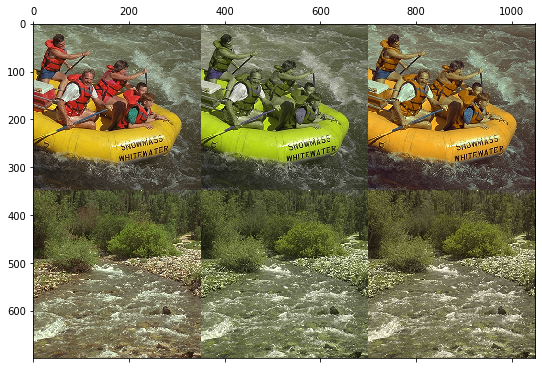

In [0]:
u1[:,2]=0
recons1 = (np.dot(u1, np.dot(np.diag(s1), v1))+ np.mean(test_img.reshape((test_img.shape[0]*test_img.shape[1],test_img.shape[2])), axis=0)).reshape((test_img.shape[0],test_img.shape[1],test_img.shape[2]))

yuv_img = np.dot(test_img, rgb2yuv)
yuv_img[:,:,2]=0
recons1_yuv = np.dot(yuv_img, yuv2rgb)
yuv_img2 = np.dot(test_img2, rgb2yuv)
yuv_img2[:,:,2]=0

u2[:,2]=0
recons2 = (np.dot(u2, np.dot(np.diag(s2), v2))+ np.mean(test_img2.reshape((test_img.shape[0]*test_img.shape[1],test_img.shape[2])), axis=0)).reshape((test_img.shape[0],test_img.shape[1],test_img.shape[2]))
recons2_yuv = np.dot(yuv_img2, yuv2rgb)

plt.matshow(np.vstack((np.hstack((test_img, recons1_yuv, recons1)),np.hstack((test_img2, recons2_yuv, recons2)))))
print(psnr(test_img, recons1_yuv), psnr(test_img, recons1), psnr(test_img2, recons2_yuv), psnr(test_img2, recons2))